### ALGORITHMIC PROGRAMMING: ORDER ACCEPTANCE AND SCHEDULING PROBLEM 

### Students: Vivens Irakoze, Ioannis Villis

### Professor: Pieter Leyman

### Introduction

The goal of this project is to address the Order Acceptance and Scheduling Problem, which involves selecting and sequencing orders to maximize profit while adhering  to constraints such as order durations, sequence-dependent setup times, and deadlines. The problem is modeled as a combination of profit maximization and scheduling under constraints: Orders must finish before their respective deadlines and tardiness penalties are applied when orders exceed their preferred finish times.

This notebook explores exact methods: the Brute-Force method, the Mixed Integer Programming Model and heuristic approaches to solve this problem efficiently. Visualization is provided through Gantt charts for insight into the scheduling outcomes.

### 1. Input Data

- ***Read Input Data:***

In [19]:
import numpy as np

# File select
fileName = 'OAS1.txt'

def readInput(fileName):
    file0=open(fileName,'r')
    #Python will read the entire file as floats, since 1 row contains floating point numbers. However, we want to store all other data as integers, which explains the astype(int) below
    data=np.loadtxt(fileName)#,dtype=float)
    
    duration=data[0].astype(int)#first line of file holds duration for each order
    profit=data[1].astype(int)#second line: profit for each order
    dueDate=data[2].astype(int)#third: due date
    deadline=data[3].astype(int)#fourth: deadline
    tardCost=data[4]#.astype(float)#fifth: tardiness cost
    numberOrders=len(duration)#can be derived from the length of any of the above

    setup=np.zeros((numberOrders,numberOrders)).astype(int)# empty array for setup
    index=0
    while index<numberOrders:
        setup[index]=data[5+index].astype(int)#5 is here to make sure Python starts with line with index 5 of input file, which is where the setup 'table' begins
        index+=1
        
    file0.close()

    #check to make sure data is imported correctly, remove for larger instances
    print(numberOrders)
    print(duration)
    print(profit)
    print(dueDate)
    print(deadline)
    print(tardCost)
    print(setup)

    return duration, profit, dueDate, deadline, tardCost, numberOrders, setup

'''>> Sample function'''
duration, profit, dueDate, deadline, tardCost, numberOrders, setup = readInput(fileName)  # Extracting relevant values from file

10
[6 1 7 9 8 8 5 8 7 6]
[78 78 21 76 32 26 46 90 76 60]
[13 32 16 40 10 34 31 21 34 35]
[37 39 22 43 13 44 45 29 44 42]
[ 3.25     11.142857  3.5      25.333333 10.666667  2.6       3.285714
 11.25      7.6       8.571429]
[[0 4 4 1 2 4 3 5 3 4]
 [4 0 3 2 1 4 1 5 2 1]
 [4 3 0 1 1 2 3 1 3 5]
 [1 2 1 0 2 5 4 4 3 3]
 [2 1 1 2 0 4 4 4 4 4]
 [4 4 2 5 4 0 3 1 5 4]
 [3 1 3 4 4 3 0 5 1 2]
 [5 5 1 4 4 1 5 0 4 1]
 [3 2 3 3 4 5 1 4 0 5]
 [4 1 5 3 4 4 2 1 5 0]]


### 2. Functions

Important methods that are used along this project are defined below:

In [20]:
from itertools import permutations

'''Start Times Calculation'''
def cal(duration, setup, sequence):
    """Calculate start and finish times for a given sequence."""
    num_orders = len(sequence)
    start_times = np.zeros(num_orders)
    finish_times = np.zeros(num_orders)

    # Initial order
    start_times[0] = 0
    finish_times[0] = duration[sequence[0]]

    # Compute times for subsequent orders
    for i in range(1, num_orders):
        prev_order = sequence[i - 1]
        current_order = sequence[i]
        start_times[i] = finish_times[i - 1] + setup[prev_order][current_order]
        finish_times[i] = start_times[i] + duration[current_order]

    return start_times, finish_times


'''Feasibility Check and Profit Calculation'''

def eval(duration, profit, dueDate, deadline, tardCost, setup, start_times, sequence):
    """Evaluate a given sequence for feasibility and objective value."""
    num_orders = len(sequence)
    start_times = np.zeros(num_orders)
    finish_times = np.zeros(num_orders)
    infeasible = False

    # Initial order
    start_times[0] = 0
    finish_times[0] = duration[sequence[0]]

    # Compute times for subsequent orders
    for i in range(1, num_orders):
        prev_order = sequence[i - 1]
        current_order = sequence[i]
        start_times[i] = finish_times[i - 1] + setup[prev_order][current_order]
        finish_times[i] = start_times[i] + duration[current_order]

    total_profit = 0
    total_tardiness_cost = 0

    for idx, order in enumerate(sequence):
        # Overlapping tasks
        if idx > 0 and start_times[idx] < finish_times[idx - 1]:
            infeasible = True
            '''
            print(f"Infeasible solution: Process of order {order + 1} overlaps with the previous order")
            '''
            return None # Return None for infeasible solution

        # Deadline exceeded
        if finish_times[idx] > deadline[order]:
            infeasible = True
            '''
            print(f"Infeasible solution: Order {order + 1} exceeds its deadline "
                  f"(finish time: {finish_times[idx]}, deadline: {deadline[order]})")
            '''     
            return None # Return None for infeasible solution

        # Profit or tardiness calculation
        if finish_times[idx] <= dueDate[order]:
            total_profit += profit[order]
        else:
            tardiness = finish_times[idx] - dueDate[order]
            total_tardiness_cost += tardiness * tardCost[order]

    # Return None for infeasible solutions
    if infeasible:
        print("There is no feasible solution.")

    return total_profit - total_tardiness_cost


- ***Visualize Input Data:***

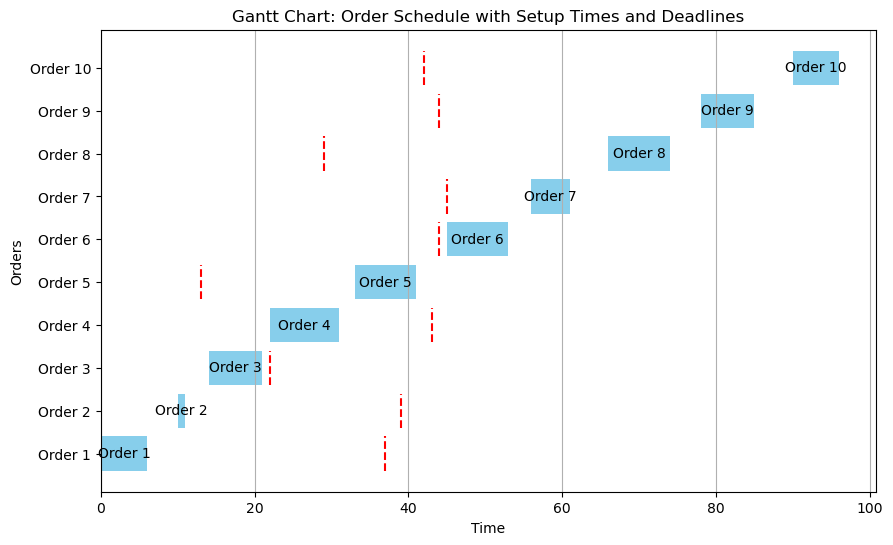

In [3]:
import matplotlib.pyplot as plt

# Gantt chart visualization function
def visualize_gantt(duration, setup, deadline):
    num_Orders = len(duration)
    
    '''Default scheduling'''
    # Initialize arrays for start times and end times
    start_times = np.zeros(num_Orders)  
    end_times = np.zeros(num_Orders)
    
    # Initial start time for the first order
    start_times[0] = 0
    end_times[0] = duration[0]
    
    for i in range(1, num_Orders):
        start_times[i] = end_times[i-1] + setup[i-1][i]  # Setup time between i-1 and i
        end_times[i] = start_times[i] + duration[i]
    
    '''Plot the Gantt chart'''
    plt.figure(figsize=(10, 6))
    
    for i in range(num_Orders):
        # Plotting the bar for each order
        plt.barh(i, end_times[i] - start_times[i], left=start_times[i], color='skyblue')
        plt.text(start_times[i] + (duration[i] / 2), i, f'Order {i+1}', ha='center', va='center')

        # Draw a vertical red line at the deadline for each order
        plt.vlines(deadline[i], i - 0.4, i + 0.4, color='red', linestyle='--')  # Deadline line for each order

    # Set the labels for the orders and the time axis
    plt.yticks(range(num_Orders), [f'Order {i+1}' for i in range(num_Orders)])
    plt.xlabel('Time')
    plt.ylabel('Orders')
    plt.title('Gantt Chart: Order Schedule with Setup Times and Deadlines')
    plt.grid(axis='x')
    plt.show()

'''>> Sample function''' # was run in the readInput file

visualize_gantt(duration, setup, deadline)

### 2. Scheduling with Desired Sequencial Scheduling

This scheduling was included to manually create a schedule which was then used to verify whether the solutions from other methods matched.

- ***Data:***

The dataset includes a list of durations for each order, profits associated with each order, due dates, a 2D array detailing the setup times between orders, and the tardiness costs for each order.

- ***Feasibility check and profit Calculation:***


In [21]:
# Sample function call
duration, profit, dueDate, deadline, tardCost, _, setup = readInput(fileName)

'''Input: Gutt-feeling Order sequence'''
sequence_input = [1, 8, 10, 2, 4]
# Convert to zero-based indexing
sequence_input0 = [x - 1 for x in sequence_input]

# Calculate start times (are then use in evaluate function)
start_times, finish_times = cal(duration, setup, sequence_input0)

# Evaluate the objective function
result = eval(duration, profit, dueDate, deadline, tardCost, setup, start_times, sequence_input0)

# Output results
print(f"Profit (after considering tardiness and setup): {result}")
print(f"Finish times: {finish_times}")


10
[6 1 7 9 8 8 5 8 7 6]
[78 78 21 76 32 26 46 90 76 60]
[13 32 16 40 10 34 31 21 34 35]
[37 39 22 43 13 44 45 29 44 42]
[ 3.25     11.142857  3.5      25.333333 10.666667  2.6       3.285714
 11.25      7.6       8.571429]
[[0 4 4 1 2 4 3 5 3 4]
 [4 0 3 2 1 4 1 5 2 1]
 [4 3 0 1 1 2 3 1 3 5]
 [1 2 1 0 2 5 4 4 3 3]
 [2 1 1 2 0 4 4 4 4 4]
 [4 4 2 5 4 0 3 1 5 4]
 [3 1 3 4 4 3 0 5 1 2]
 [5 5 1 4 4 1 5 0 4 1]
 [3 2 3 3 4 5 1 4 0 5]
 [4 1 5 3 4 4 2 1 5 0]]
Profit (after considering tardiness and setup): 382
Finish times: [ 6. 19. 26. 28. 39.]


- ***Visualization:***

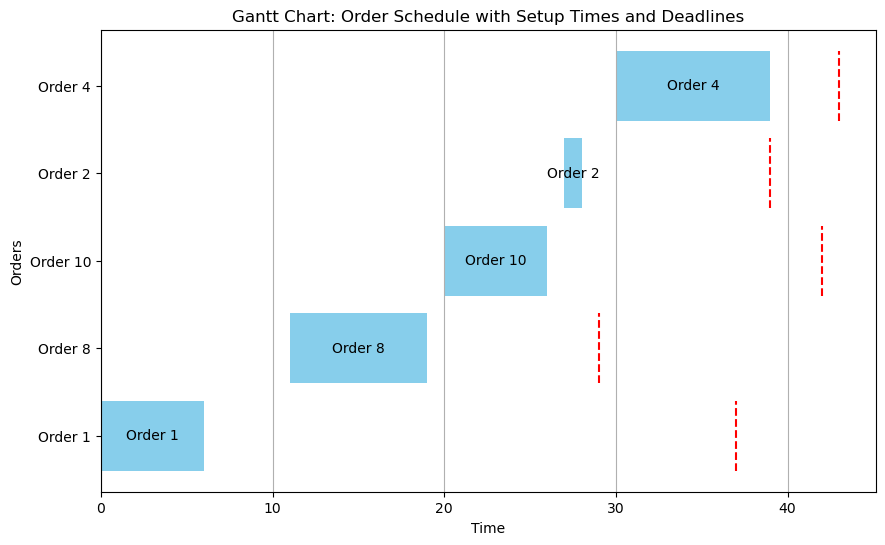

10

In [22]:
import matplotlib.pyplot as plt

# Gantt chart visualization function
def visualize_gantt(duration, sequence, start_times, deadline):  # sequence == sequence_input
    num_orders = len(sequence)

    # Initialize arrays for end times
    end_times = np.zeros(num_orders)
    
    # Calculate the finish times based on start_times and duration
    for i in range(len(sequence)):  
        order_index = sequence[i] - 1
        end_times[i] = start_times[i] + duration[order_index] # Finish times for visualization

    # Plotting the Gantt chart
    plt.figure(figsize=(10, 6))

    for i in range(num_orders):
        # Draw the bar for each order
        plt.barh(i, end_times[i] - start_times[i], left=start_times[i], color='skyblue')
        plt.text(start_times[i] + (end_times[i] - start_times[i]) / 2, i, f'Order {sequence[i]}', ha='center', va='center')

        # Draw a vertical red line at the deadline for each order
        plt.vlines(deadline[sequence[i] - 1], i - 0.4, i + 0.4, color='red', linestyle='--') 

    # Set labels for orders and time axis
    plt.yticks(range(num_orders), [f'Order {sequence[i]}' for i in range(num_orders)])
    plt.xlabel('Time')
    plt.ylabel('Orders')
    plt.title('Gantt Chart: Order Schedule with Setup Times and Deadlines')
    plt.grid(axis='x')

    plt.show()

'''>> Sample is already done in the previous visualization'''

visualize_gantt(duration, sequence_input, start_times, deadline) 
_

### 4. Exact Solution Methods

#### 4.1. Brute-Force Method

**Brute-Force Scheduling**: The brute-force method will involve checking all possible permutations of order sequences, evaluating each permutation for feasibility and profit.

**Enumerate and Permutations**: Instead of using combinations like in the knapsack problem, we chose to use permutations because every order must be scheduled in a sequence, and the order of scheduling will impact the total profit.

**Feasibility and Profit Calculation**: For each sequence of orders, we will check if it is feasible (i.e., no overlap, no orders exceeding their deadlines), and calculate the profit and tardiness.

#### **conclusion**:

Although Brute Force gives optimal solutions, It is not suitable for large n because it takes exponetially increasing run time with n.


- ***Code:***

In [6]:
class Brute_Force_Schedule:
    def __init__(self, duration, profit, dueDate, deadline, tardCost, setup, start_times):
        self.duration = duration
        self.profit = profit
        self.dueDate = dueDate
        self.deadline = deadline
        self.tardCost = tardCost
        self.start_times = start_times  # not really used, just to call eval
        self.setup = setup

    def enumerate_solutions(self):
        """Enumerate all possible solutions using Permutations."""
        best_profit = -float('inf')
        best_sequence = None
        best_finish_times = None

        num_orders = len(self.duration)
        all_solutions = []

        # Iterate through all possible sequences of orders
        for r in range(1, num_orders + 1):  # Include partial solutions with 1 to num_orders orders
            for seq_index, sequence in enumerate(permutations(range(num_orders), r)):
                result = eval(
                    self.duration,
                    self.profit,
                    self.dueDate,
                    self.deadline,
                    self.tardCost,
                    self.setup,
                    self.start_times,
                    sequence,
                )
                if result is not None:
                    all_solutions.append((sequence, result))

                    # Update the best solution if needed
                    if result > best_profit:
                        best_profit = result
                        best_sequence = tuple(order + 1 for order in sequence)  # Convert sequence to 1-based
                        _, best_finish_times = cal(self.duration, self.setup, sequence)

        return best_profit, best_sequence, best_finish_times


'''>> Call Samples'''
duration, profit, dueDate, deadline, tardCost, _, setup = readInput(fileName)

# Initialize the scheduler
scheduler = Brute_Force_Schedule(duration, profit, dueDate, deadline, tardCost, setup, start_times)

'''Enumerate call eval'''
# Find the best schedule using enumeration of all feasible solutions
best_profit, best_sequence, best_finish_times = scheduler.enumerate_solutions()

# Get and print the best solution
if best_profit != -float('inf'):
    print(f"Best Profit: {best_profit}")
    print(f"Best Sequence: {best_sequence}")
    print(f"Finish Times: {best_finish_times}")
else:
    print("No feasible solution found.")


10
[6 1 7 9 8 8 5 8 7 6]
[78 78 21 76 32 26 46 90 76 60]
[13 32 16 40 10 34 31 21 34 35]
[37 39 22 43 13 44 45 29 44 42]
[ 3.25     11.142857  3.5      25.333333 10.666667  2.6       3.285714
 11.25      7.6       8.571429]
[[0 4 4 1 2 4 3 5 3 4]
 [4 0 3 2 1 4 1 5 2 1]
 [4 3 0 1 1 2 3 1 3 5]
 [1 2 1 0 2 5 4 4 3 3]
 [2 1 1 2 0 4 4 4 4 4]
 [4 4 2 5 4 0 3 1 5 4]
 [3 1 3 4 4 3 0 5 1 2]
 [5 5 1 4 4 1 5 0 4 1]
 [3 2 3 3 4 5 1 4 0 5]
 [4 1 5 3 4 4 2 1 5 0]]
Best Profit: 382
Best Sequence: (1, 8, 10, 2, 4)
Finish Times: [ 6. 19. 26. 28. 39.]


- ***Visualization:***

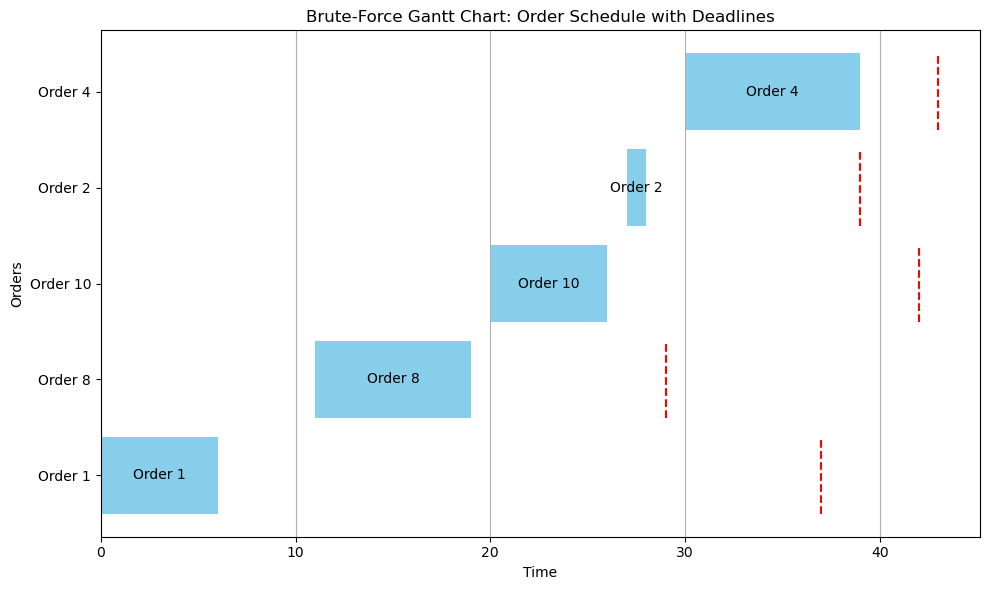

In [7]:
import matplotlib.pyplot as plt

# Gantt chart visualization function for the brute-force schedule
def visualize_brute_force_schedule(best_sequence, best_finish_times, deadline, duration):
    if best_sequence is None or best_finish_times is None:
        print("No feasible solution to visualize.")
        return

    num_orders = len(best_sequence)
    zero_based_sequence = [order - 1 for order in best_sequence]
    start_times = [best_finish_times[i] - duration[zero_based_sequence[i]] for i in range(num_orders)]

    plt.figure(figsize=(10, 6))

    for i, order in enumerate(zero_based_sequence):
        # Plot the bar for each order
        plt.barh(i, duration[order], left=start_times[i], color='skyblue')
        plt.text(start_times[i] + duration[order] / 2, i, f"Order {order + 1}", ha='center', va='center')

        # Plot the deadline line
        plt.vlines(deadline[order], i - 0.4, i + 0.4, color='red', linestyle='--')

    # Set the labels for the orders and the time axis
    plt.yticks(range(num_orders), [f"Order {order + 1}" for order in zero_based_sequence])
    plt.xlabel("Time")
    plt.ylabel("Orders")
    plt.title("Brute-Force Gantt Chart: Order Schedule with Deadlines")
    plt.grid(axis='x')
    plt.tight_layout()
    plt.show()

visualize_brute_force_schedule(best_sequence, best_finish_times, deadline, duration)


#### 4.2 MIP Solution using Gurobi

This is a Mixed Integer Programming (MIP) model designed for a scheduling problem. The objective is to maximize the profit of scheduled orders while minimizing tardiness costs, subject to several constraints related to order precedence, deadlines, and feasibility. The method incorporates binary decision variables for sequencing and scheduling orders, as well as continuous variables for tracking finish times and tardiness.

### ***Conclusion :***

MIP optimizer use a method that uses advanced techniques like **branch-and-bound**, **constraint relaxation**, and **cutting planes** to find the optimal solution efficiently. although it is highly reliable, it takes extra computational power and time for more complex and large n. This has led to introduction of model parameters which limit the run time of the optimization.



- ***Code :***

In [8]:
import gurobipy as gp
from gurobipy import GRB
import numpy as np

'''>> Call Samples'''
duration, profit, dueDate, deadline, tardCost, numberOrders, setup = readInput(fileName)

# Adding setup times and durations for the dummy start (0) and end (n+1) nodes
setup_expanded = np.zeros((numberOrders + 2, numberOrders + 2)).astype(int)
duration_expanded = np.zeros(numberOrders + 2).astype(int)

setup_expanded[1:numberOrders + 1, 1:numberOrders + 1] = setup
duration_expanded[1:numberOrders + 1] = duration

# Create the Gurobi model
model = gp.Model("MIP_Scheduling")

# Decision variables
x = model.addVars(numberOrders + 2, numberOrders + 2, vtype=GRB.BINARY, name="x")  # Does order i precede order j
y = model.addVars(numberOrders + 2, vtype=GRB.BINARY, name="y")                    # Is order i scheduled?
f = model.addVars(numberOrders + 2, vtype=GRB.CONTINUOUS, name="f")                # Finish times
T = model.addVars(numberOrders + 2, vtype=GRB.CONTINUOUS, name="T")                # Tardiness

# Large constant for big-M constraints
M = 1000

'''Objective Function'''
# Maximize profit - tardiness cost, only for actual orders
model.setObjective(
    gp.quicksum(profit[i - 1] * y[i] for i in range(1, numberOrders + 1)) -
    gp.quicksum(tardCost[i - 1] * T[i] for i in range(1, numberOrders + 1)),
    GRB.MAXIMIZE
)

'''Constraints'''
# 1. One successor per job (including dummy jobs)
for i in range(numberOrders + 1):  # including dummy start node
    model.addConstr(
        gp.quicksum(x[i, j] for j in range(1, numberOrders + 2) if i != j) == y[i],
        name=f"successor_{i}"
    )

# 2. Job cannot precede itself
for i in range(numberOrders + 2):
    model.addConstr(x[i, i] == 0, name=f"no_self_precedence_{i}")

# 3. One predecessor per job
for i in range(1, numberOrders + 2):  # including dummy end node
    model.addConstr(
        gp.quicksum(x[j, i] for j in range(numberOrders + 1) if i != j) == y[i],
        name=f"predecessor_{i}"
    )

# 4. Order sequencing
for i in range(numberOrders + 1):  # Including dummy start node
    for j in range(1, numberOrders + 2):  # Including dummy end node
        if i != j:
            model.addConstr(
                f[i] + (setup_expanded[i, j] + duration_expanded[j]) * x[i, j] - M * (1 - x[i, j]) <= f[j],
                name=f"seq_{i}_{j}"
            )

# 5. Deadline
for i in range(1, numberOrders + 1):  # Only for actual jobs (exclude dummies)
    model.addConstr(f[i] <= deadline[i - 1] * y[i], name=f"deadline_{i}")

# 6. Tardiness
for i in range(1, numberOrders + 1):  # Only for actual jobs (exclude dummies)
    model.addConstr(T[i] >= f[i] - dueDate[i - 1] - M * (1 - y[i]), name=f"tardiness_{i}")
    model.addConstr(T[i] >= 0, name=f"tard_0_{i}")
    model.addConstr(T[i] <= M * y[i], name=f"tard_limit_{i}")


'''Optimization Parameters'''
# Set a time limit
model.setParam('TimeLimit', 900)  # Limit to 15 minutes
# Allow a small gap between the optimal solution and best feasible solution
model.setParam('MIPGap', 0.05)    # 5% gap
# Allocate time for heuristics
#model.setParam('Heuristics', 0.2) 

# Solve the model
model.optimize()

# Extract and print results
if model.status == GRB.OPTIMAL:
    print("Optimal solution found.")
    print("Profit (Objective Value): {:.2f}".format(model.objVal))
    
    print("\nScheduled Orders:")
    for i in range(1, numberOrders + 1):  # Excluding dummy start and end nodes
        if y[i].x > 0.5:  # If the order is scheduled
            print(f"  Order {i}: Finish Time = {f[i].x:.2f}, Tardiness = {T[i].x:.2f}")
else:
    print("No optimal solution found.")


10
[6 1 7 9 8 8 5 8 7 6]
[78 78 21 76 32 26 46 90 76 60]
[13 32 16 40 10 34 31 21 34 35]
[37 39 22 43 13 44 45 29 44 42]
[ 3.25     11.142857  3.5      25.333333 10.666667  2.6       3.285714
 11.25      7.6       8.571429]
[[0 4 4 1 2 4 3 5 3 4]
 [4 0 3 2 1 4 1 5 2 1]
 [4 3 0 1 1 2 3 1 3 5]
 [1 2 1 0 2 5 4 4 3 3]
 [2 1 1 2 0 4 4 4 4 4]
 [4 4 2 5 4 0 3 1 5 4]
 [3 1 3 4 4 3 0 5 1 2]
 [5 5 1 4 4 1 5 0 4 1]
 [3 2 3 3 4 5 1 4 0 5]
 [4 1 5 3 4 4 2 1 5 0]]
Set parameter WLSAccessID
Set parameter WLSSecret
Set parameter LicenseID to value 2560044
Academic license 2560044 - for non-commercial use only - registered to vi___@ugent.be
Set parameter TimeLimit to value 900
Set parameter MIPGap to value 0.05
Gurobi Optimizer version 12.0.0 build v12.0.0rc1 (win64 - Windows 10.0 (19045.2))

CPU model: Intel(R) Core(TM) i5-8250U CPU @ 1.60GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Non-default parameters:
TimeLimit  900
MIPGap  0.05

- ***Visualization:***

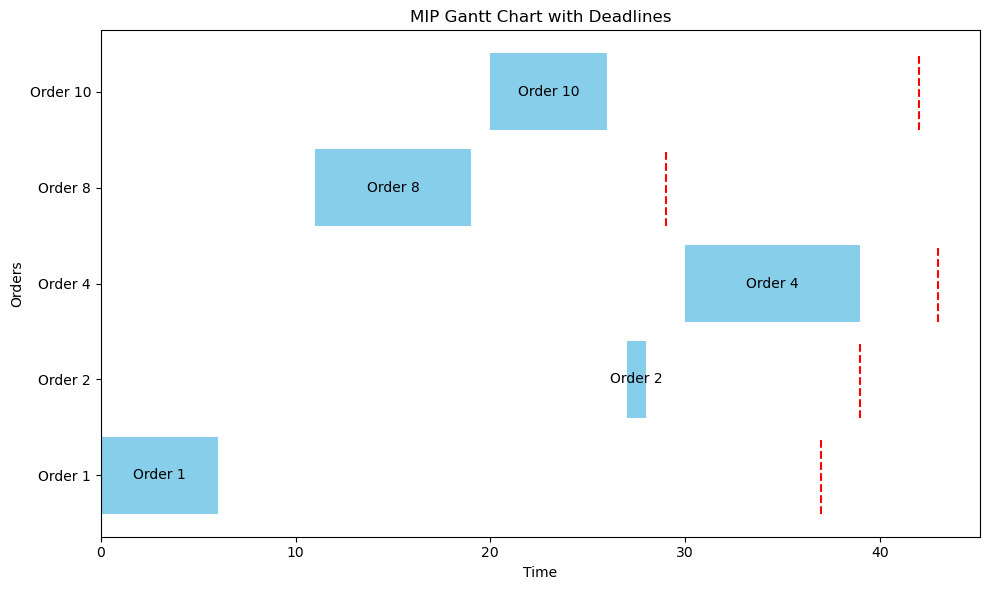

In [9]:
'''Extract from MIP model'''
if model.status == GRB.OPTIMAL or model.status == GRB.TIME_LIMIT or model.status == GRB.INFEASIBLE:
    # Extract the relevant MIP results
    f_mip = [f[i].x for i in range(numberOrders + 2)]  
    y_mip = [y[i].x for i in range(1, numberOrders + 1)]  
    tardiness_mip = [T[i].x for i in range(1, numberOrders + 1)]  
    scheduled_orders = [i for i in range(1, numberOrders + 1) if y_mip[i - 1] > 0.5]
    finish_times = [f_mip[i] for i in range(1, numberOrders + 1) if y_mip[i - 1] > 0.5]

    '''Visualization'''
    import matplotlib.pyplot as plt

    # Create Gantt chart
    fig, ax = plt.subplots(figsize=(10, 6))
    current_time = 0

    for order in scheduled_orders:
        start_time = finish_times[scheduled_orders.index(order)] - duration[order - 1]
        
        # Plot the order's duration as a bar
        ax.barh(f"Order {order}", duration[order - 1], left=start_time, color='skyblue')
        
        # Add text label on the bar
        ax.text(start_time + duration[order - 1] / 2, f"Order {order}", f"Order {order}",
                ha='center', va='center', fontsize=10, color='black')

        # Plot a redline for the deadline in the respective row
        ax.vlines(deadline[order - 1], scheduled_orders.index(order) - 0.4, scheduled_orders.index(order) + 0.4, 
                  color='red', linestyle='--')

        # Add setup times between consecutive orders (optional, if setup needs to be shown)
        if scheduled_orders.index(order) > 0:
            prev_order = scheduled_orders[scheduled_orders.index(order) - 1]
            setup_time = setup[prev_order - 1][order - 1]
            current_time += setup_time

        current_time = start_time + duration[order - 1]

    # Chart formatting
    ax.set_xlabel("Time")
    ax.set_ylabel("Orders")
    ax.set_title("MIP Gantt Chart with Deadlines")
    plt.tight_layout()
    plt.show()

else:
    print("No Solution Found.")


The Gantt chart above validates the MIP solution by visually confirming adherence to sequencing, selection, and deadline constraints while demonstrating the effective utilization of decision variables (yi, fi, xij, Ti ). It also highlights the MIP model's capability to produce an optimal schedule under given constraints.

### 4.3 Greedy construction heuristics

While the exact solution method provide the optimal solution, their run time increase exponentially as n increase. In this section we introduce heuristic methods which are rule-of-thumb procedure that provides good solutions within reasonable times, but for which optimality cannot be guaranteed.

#### Implementation of a greedy construction heuristic

- **insertion():**

Starts with an empty schedule.
Adds orders one at a time, selecting the order whose addition results in the highest profit increase while maintaining feasibility.
This is a bottom-up approach.

- **savings():**

Starts with all orders scheduled (possibly infeasible with respect to total duration).
Iteratively removes the order with the lowest profit until the solution becomes feasible.
This is a top-down approach

**4.3.1 Insertion Heuristic**: The insertion heuristic builds a schedule iteratively, starting with an empty solution. At each step, it selects the order whose insertion into the current schedule yields the maximum profit increase while maintaining feasibility (e.g., respecting the total duration limit and deadlines). The process continues until no additional order can be feasibly inserted

In [10]:
def insertion(duration, profit, dueDate, deadline, tardCost, numberOrders, setup):
    """Greedy insertion heuristic for scheduling. Insert one order at a time."""
    remaining_orders = list(range(numberOrders))  # List of orders that need to be scheduled
    scheduled_orders = []  # List to store the scheduled orders
    total_profit = 0  # Variable to store the total profit

    while remaining_orders:
        best_profit_increase = -float('inf')  # Initialize best profit increase
        best_order_to_insert = -1  # The order that gives the best profit increase
        best_insertion_position = -1  # The position where the best order should be inserted

        # Try to insert each remaining order and evaluate the profit increase
        for order in remaining_orders:
            best_position = -1  # Position where the order will be inserted
            profit_increase = -float('inf')  # Initialize profit increase for this order

            # Try inserting the order at every possible position in the current schedule
            for position in range(len(scheduled_orders) + 1):
                # Create a new sequence with the order inserted at the current position
                new_sequence = scheduled_orders[:position] + [order] + scheduled_orders[position:]

                # Calculate start and finish times for this new sequence
                start_times, finish_times = cal(duration, setup, new_sequence)

                # Evaluate the new sequence (profit and feasibility check)
                seq_profit = eval(duration, profit, dueDate, deadline, tardCost, setup, start_times, new_sequence)

                # Only consider this position if the sequence is feasible (seq_profit is not None)
                if seq_profit is not None and seq_profit > profit_increase:
                    profit_increase = seq_profit
                    best_position = position

            # If this insertion results in a higher profit, update the best choice
            if profit_increase > best_profit_increase:
                best_profit_increase = profit_increase
                best_order_to_insert = order
                best_insertion_position = best_position

        # If a feasible insertion was found, insert the order
        if best_order_to_insert != -1:
            remaining_orders.remove(best_order_to_insert)  # Remove the chosen order from remaining orders
            scheduled_orders.insert(best_insertion_position, best_order_to_insert)  # Insert the order at the best position

            # Recalculate the total profit for the current schedule
            start_times, finish_times = cal(duration, setup, scheduled_orders)
            total_profit = eval(duration, profit, dueDate, deadline, tardCost, setup, start_times, scheduled_orders)

        # If no feasible solution is found (though unlikely), break the loop
        if best_profit_increase == -float('inf'):
            break

    return scheduled_orders, total_profit

# Run the insertion heuristic
scheduled_orders, total_profit = insertion(duration, profit, dueDate, deadline, tardCost, numberOrders, setup)

# Visualize the schedule using a Gantt chart
print(f"Scheduled Orders: {scheduled_orders}")
print(f"Total Profit: {total_profit}")

Scheduled Orders: [0, 7, 9, 1, 3]
Total Profit: 382


- ***Visualization :***

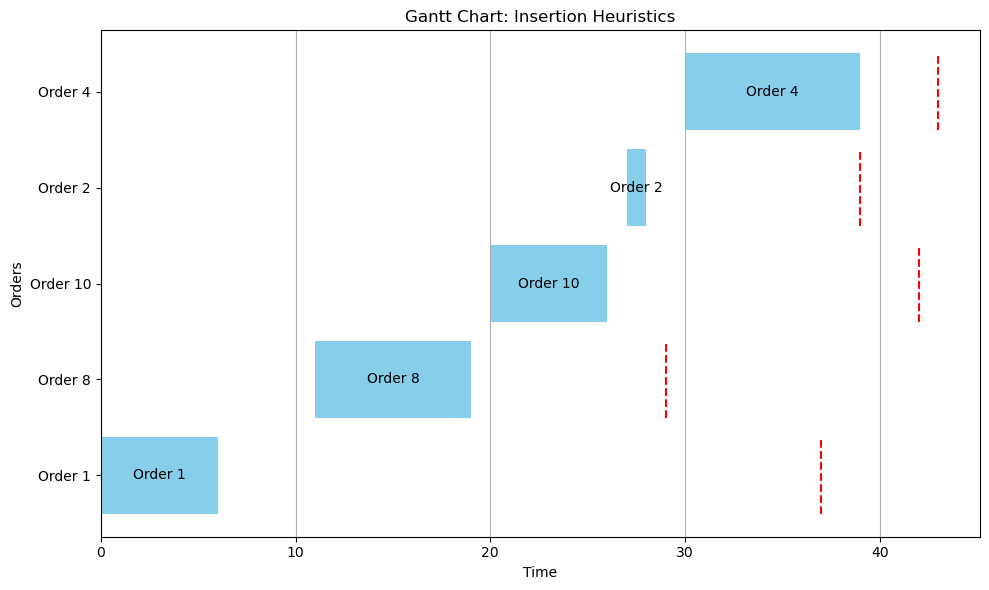

In [11]:
import matplotlib.pyplot as plt

def visualize_gantt(duration, setup, deadline, scheduled_orders):
    """
    Function to visualize the schedule using a Gantt chart.
    """
    if not scheduled_orders:
        print("No scheduled orders to visualize.")
        return

    num_orders = len(scheduled_orders)
    start_times = [0] * num_orders
    finish_times = [0] * num_orders

    # Calculate start and finish times for each order
    for i, order in enumerate(scheduled_orders):
        if i == 0:
            start_times[i] = 0
        else:
            prev_order = scheduled_orders[i - 1]
            start_times[i] = finish_times[i - 1] + setup[prev_order][order]
        finish_times[i] = start_times[i] + duration[order]

    # Create the Gantt chart
    plt.figure(figsize=(10, 6))

    for i, order in enumerate(scheduled_orders):
        # Plot the bar for each order
        plt.barh(i, finish_times[i] - start_times[i], left=start_times[i], color='skyblue')
        plt.text(start_times[i] + (finish_times[i] - start_times[i]) / 2, i,
                 f"Order {order + 1}", ha='center', va='center', fontsize=10)

        # Plot the deadline line
        plt.vlines(deadline[order], i - 0.4, i + 0.4, color='red', linestyle='--')

    # Set labels and title
    plt.yticks(range(num_orders), [f"Order {order + 1}" for order in scheduled_orders])
    plt.xlabel("Time")
    plt.ylabel("Orders")
    plt.title("Gantt Chart: Insertion Heuristics")
    plt.grid(axis='x')
    plt.tight_layout()
    plt.show()

visualize_gantt(duration, setup, deadline, scheduled_orders)


**4.3.2 Savings Heuristic**: The savings heuristic starts with a schedule containing all orders, regardless of feasibility. It iteratively removes the order with the lowest profit contribution until the schedule becomes feasible. Feasibility is evaluated based on constraints such as total duration and order deadlines.

In [12]:
def savings(duration, profit, dueDate, deadline, tardCost, numberOrders, setup, max_duration):
    """
    Savings heuristic: Starts from a solution with all orders (infeasible) and iteratively remove
    the order with the lowest profit until the solution is feasible, ensuring no overlaps, deadlines are met,
    and total duration does not exceed desired duration.
    """
    # Start with all orders in the solution (neglect infeasibility)
    scheduled_orders = list(range(numberOrders))
    
    # Calculate initial start and finish times
    start_times, finish_times = cal(duration, setup, scheduled_orders)
    total_duration = finish_times[-1] if finish_times.size > 0 else 0  # Total duration based on the last finish time
    
    # Check if the initial schedule is feasible
    if savings_feasible(start_times, finish_times, scheduled_orders, deadline, total_duration, max_duration):
        total_profit = sum(profit[o] for o in scheduled_orders)  # Total profit of all scheduled orders
        return scheduled_orders, total_profit

    # Keep removing the order with the lowest profit until the solution is feasible
    while not savings_feasible(start_times, finish_times, scheduled_orders, deadline, total_duration, max_duration) and scheduled_orders:
        # Find the order with the lowest profit
        min_profit_order = min(scheduled_orders, key=lambda o: profit[o])
        
        # Remove the order with the lowest profit
        scheduled_orders.remove(min_profit_order)
        
        # Recalculate start and finish times
        start_times, finish_times = cal(duration, setup, scheduled_orders)
        total_duration = finish_times[-1] if finish_times.size > 0 else 0

    # Calculate the total profit for the feasible schedule
    total_profit = sum(profit[o] for o in scheduled_orders)

    return scheduled_orders, total_profit , total_duration


def savings_feasible(start_times, finish_times, scheduled_orders, deadline, total_duration, max_duration):
    """
    Checks if the solution is feasible based on the provided conditions:
    1. Tasks must not overlap.
    2. No task can exceed its deadline.
    3. Total duration must not exceed max_duration.
    """
    for idx, order in enumerate(scheduled_orders):
        # Overlapping tasks
        if idx > 0 and start_times[idx] < finish_times[idx - 1]:
            return False  # Overlap detected
        
        # Deadline exceeded
        if finish_times[idx] > deadline[order]:
            return False  # Deadline violation detected

    # Check if total duration exceeds the allowed max duration
    if total_duration > max_duration:
        return False  # Total duration violation detected

    return True  # All conditions satisfied


'''>> Desired Total Duration Limit'''
max_duration = 30  # Example maximum duration constraint

scheduled_orders, total_profit, total_duration = savings(duration, profit, dueDate, deadline, tardCost, numberOrders, setup, max_duration)

# Display the schedule and total profit
print(f"Scheduled Orders: {scheduled_orders}")
print(f"Total Profit: {total_profit}")
print(f"Total Duration: {total_duration}")


Scheduled Orders: [0, 1, 7]
Total Profit: 246
Total Duration: 24.0


- ***Visualization :***

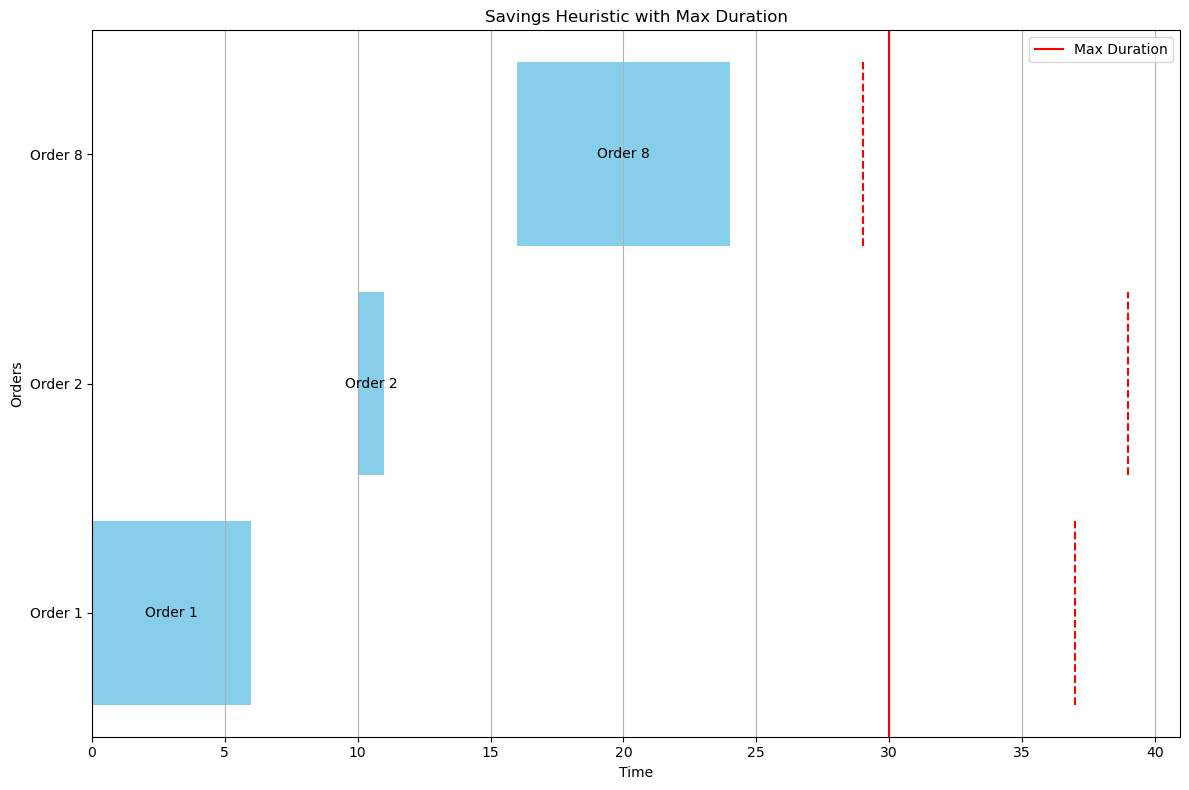

In [13]:
def visualize_savings_gantt(duration, setup, deadline, scheduled_orders, max_duration):
    """
    Visualize the schedule generated by the savings heuristic using a Gantt chart.
    """
    if not scheduled_orders:
        print("No scheduled orders to visualize.")
        return

    num_orders = len(scheduled_orders)
    start_times = [0] * num_orders
    finish_times = [0] * num_orders

    # Calculate start and finish times for each order
    for i, order in enumerate(scheduled_orders):
        if i == 0:
            start_times[i] = 0
        else:
            prev_order = scheduled_orders[i - 1]
            start_times[i] = finish_times[i - 1] + setup[prev_order][order]
        finish_times[i] = start_times[i] + duration[order]

    # Create the Gantt chart
    plt.figure(figsize=(12, 8))

    for i, order in enumerate(scheduled_orders):
        # Plot the bar for each order
        plt.barh(i, finish_times[i] - start_times[i], left=start_times[i], color='skyblue')
        plt.text(start_times[i] + (finish_times[i] - start_times[i]) / 2, i,
                 f"Order {order + 1}", ha='center', va='center', fontsize=10)

        # Plot the deadline line
        plt.vlines(deadline[order], i - 0.4, i + 0.4, color='red', linestyle='--')

    # Plot the maximum duration constraint as a vertical line
    plt.axvline(max_duration, color='red', linestyle='-', label='Max Duration')

    # Set labels and title
    plt.yticks(range(num_orders), [f"Order {order + 1}" for order in scheduled_orders])
    plt.xlabel("Time")
    plt.ylabel("Orders")
    plt.title("Savings Heuristic with Max Duration")
    plt.legend()
    plt.grid(axis='x')
    plt.tight_layout()
    plt.show()

# Assuming `scheduled_orders` is obtained from the `savings()` function:
scheduled_orders, total_profit, total_duration = savings(duration, profit, dueDate, deadline, tardCost, numberOrders, setup, max_duration)

# Visualize the schedule
visualize_savings_gantt(duration, setup, deadline, scheduled_orders, max_duration)


### 4.4 Local Search Improvement Heuristics

Local search heuristics aim to improve an existing feasible solution by exploring its neighborhood. These heuristics apply small, localized changes to the current solution and move to a neighboring solution if it improves the objective (e.g., total profit). The process continues until no further improvements can be found, yielding a locally optimal solution.

Three local search heuristics were implemented in the project:

**Move**: Remove an order from the schedule and reinsert it in a different position.

**Swap**: Swap the positions of two orders in the schedule.

**Custom Improvement**: A user-defined local search operator designed to explore more complex neighborhoods.

- ***code :***

In [14]:
import numpy as np

# Read input data function
def readInput(fileName):
    data = np.loadtxt(fileName)
    durations = data[0].astype(int)
    profits = data[1].astype(int)
    due_dates = data[2].astype(int)
    deadlines = data[3].astype(int)
    tardiness_costs = data[4]
    setup_times = data[5:].astype(int)

    return {
        'duration': durations,
        'profit': profits,
        'dueDate': due_dates,
        'deadline': deadlines,
        'tardCost': tardiness_costs,
        'setup': setup_times
    }

# Adjusted evaluation function (profit minus penalty only)
def refined_evaluate_solution(solution, durations, profits, deadlines, tardiness_costs, setup_times):
    total_profit = 0
    total_time = 0
    total_penalty = 0

    for i, order in enumerate(solution):
        # Add profit
        total_profit += profits[order]

        # Add setup time
        if i > 0:
            total_time += setup_times[solution[i-1]][order]

        # Add duration
        total_time += durations[order]

        # Calculate tardiness penalty
        if total_time > deadlines[order]:
            penalty = tardiness_costs[order] * (total_time - deadlines[order])
            total_penalty += penalty

    # Final evaluation score
    evaluation_score = total_profit - (0.5 * total_penalty)
    return evaluation_score

# Enhanced initialization
def enhanced_initialization(durations, profits, deadlines, tardiness_costs, setup_times):
    job_scores = []
    for i in range(len(profits)):
        # Profit-to-duration ratio weighted by tardiness cost
        score = (profits[i] / durations[i]) - (tardiness_costs[i] / max(deadlines[i], 1))
        job_scores.append((i, score))

    # Sort jobs by descending score
    sorted_jobs = sorted(job_scores, key=lambda x: x[1], reverse=True)
    return [job[0] for job in sorted_jobs]

# Move heuristic
def move(current_solution, evaluate, durations, profits, deadlines, tardiness_costs, setup_times):
    n = len(current_solution)
    best_solution = current_solution.copy()
    best_evaluation = evaluate(current_solution, durations, profits, deadlines, tardiness_costs, setup_times)

    for i in range(n):
        for j in range(n):
            if i != j:
                neighbor = current_solution.copy()
                order = neighbor.pop(i)
                neighbor.insert(j, order)

                neighbor_evaluation = evaluate(neighbor, durations, profits, deadlines, tardiness_costs, setup_times)
                if neighbor_evaluation > best_evaluation:
                    best_evaluation = neighbor_evaluation
                    best_solution = neighbor

    return best_solution, best_evaluation

# Swap heuristic
def swap(current_solution, evaluate, durations, profits, deadlines, tardiness_costs, setup_times):
    n = len(current_solution)
    best_solution = current_solution.copy()
    best_evaluation = evaluate(current_solution, durations, profits, deadlines, tardiness_costs, setup_times)

    for i in range(n):
        for j in range(i + 1, n):
            neighbor = current_solution.copy()
            neighbor[i], neighbor[j] = neighbor[j], neighbor[i]

            neighbor_evaluation = evaluate(neighbor, durations, profits, deadlines, tardiness_costs, setup_times)
            if neighbor_evaluation > best_evaluation:
                best_evaluation = neighbor_evaluation
                best_solution = neighbor

    return best_solution, best_evaluation

# Two-opt heuristic
def two_opt(current_solution, evaluate, durations, profits, deadlines, tardiness_costs, setup_times):
    n = len(current_solution)
    best_solution = current_solution.copy()
    best_evaluation = evaluate(current_solution, durations, profits, deadlines, tardiness_costs, setup_times)

    for i in range(n - 1):
        for j in range(i + 1, n):
            neighbor = current_solution.copy()
            neighbor[i:j+1] = reversed(neighbor[i:j+1])

            neighbor_evaluation = evaluate(neighbor, durations, profits, deadlines, tardiness_costs, setup_times)
            if neighbor_evaluation > best_evaluation:
                best_evaluation = neighbor_evaluation
                best_solution = neighbor

    return best_solution, best_evaluation

# Combined refinement function
def hybrid_refine(current_solution, evaluate, durations, profits, deadlines, tardiness_costs, setup_times):
    solution = current_solution.copy()
    best_evaluation = evaluate(solution, durations, profits, deadlines, tardiness_costs, setup_times)

    for iteration in range(30):  # Extended refinement iterations
        # Move heuristic
        new_solution, new_evaluation = move(solution, evaluate, durations, profits, deadlines, tardiness_costs, setup_times)
        if new_evaluation > best_evaluation:
            best_evaluation = new_evaluation
            solution = new_solution

        # Swap heuristic
        new_solution, new_evaluation = swap(solution, evaluate, durations, profits, deadlines, tardiness_costs, setup_times)
        if new_evaluation > best_evaluation:
            best_evaluation = new_evaluation
            solution = new_solution

        # Two-opt heuristic
        new_solution, new_evaluation = two_opt(solution, evaluate, durations, profits, deadlines, tardiness_costs, setup_times)
        if new_evaluation > best_evaluation:
            best_evaluation = new_evaluation
            solution = new_solution
            
    return solution, best_evaluation

# Main program
if __name__ == "__main__":
    # Load data
    data = readInput('OAS1.txt')
    durations = data['duration']
    profits = data['profit']
    deadlines = data['deadline']
    tardiness_costs = data['tardCost']
    setup_times = data['setup']

    # Enhanced initialization
    initial_solution = enhanced_initialization(durations, profits, deadlines, tardiness_costs, setup_times)
    print("Enhanced Initial Solution:", initial_solution)
    print("Initial Evaluation:", refined_evaluate_solution(initial_solution, durations, profits, deadlines, tardiness_costs, setup_times))

    # Hybrid refinement
    best_solution, best_evaluation = hybrid_refine(initial_solution, refined_evaluate_solution, durations, profits, deadlines, tardiness_costs, setup_times)
    print("Refined Solution:", best_solution)
    print("Refined Evaluation:", best_evaluation)



Enhanced Initial Solution: [1, 0, 7, 8, 9, 6, 3, 5, 4, 2]
Initial Evaluation: -334.86905649999994
Refined Solution: [4, 3, 7, 9, 1, 6, 8, 0, 2, 5]
Refined Evaluation: 341.2857145


- ***Visualization :***

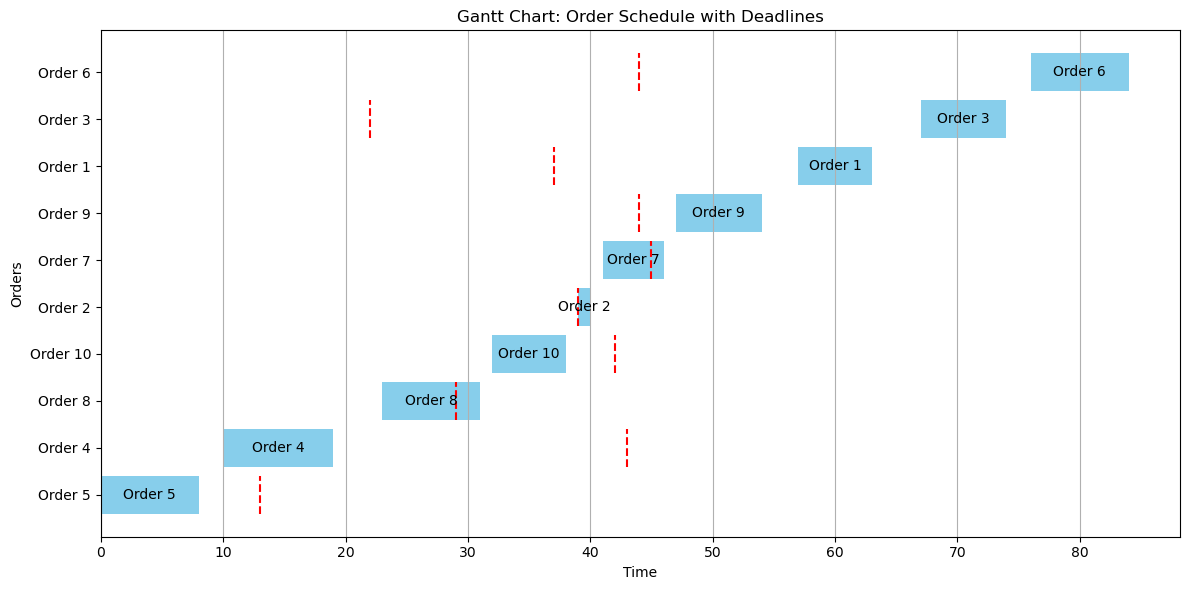

In [15]:
import matplotlib.pyplot as plt

def visualize_gantt(duration, setup, deadline, scheduled_orders):
    """
    Function to visualize the schedule using a Gantt chart.
    """
    if not scheduled_orders:
        print("No scheduled orders to visualize.")
        return

    num_orders = len(scheduled_orders)
    start_times = [0] * num_orders
    finish_times = [0] * num_orders

    # Calculate start and finish times for each order
    for i, order in enumerate(scheduled_orders):
        if i == 0:
            start_times[i] = 0
        else:
            prev_order = scheduled_orders[i - 1]
            start_times[i] = finish_times[i - 1] + setup[prev_order][order]
        finish_times[i] = start_times[i] + duration[order]

    # Create the Gantt chart
    plt.figure(figsize=(12, 6))

    for i, order in enumerate(scheduled_orders):
        # Plot the bar for each order
        plt.barh(i, finish_times[i] - start_times[i], left=start_times[i], color='skyblue')
        plt.text(start_times[i] + (finish_times[i] - start_times[i]) / 2, i,
                 f"Order {order + 1}", ha='center', va='center', fontsize=10)

        # Plot the deadline line
        plt.vlines(deadline[order], i - 0.4, i + 0.4, color='red', linestyle='--')

    # Set labels and title
    plt.yticks(range(num_orders), [f"Order {order + 1}" for order in scheduled_orders])
    plt.xlabel("Time")
    plt.ylabel("Orders")
    plt.title("Gantt Chart: Order Schedule with Deadlines")
    plt.grid(axis='x')
    plt.tight_layout()
    plt.show()

# Visualize the refined solution as a Gantt chart
visualize_gantt(durations, setup_times, deadlines, best_solution)


### Conclusion

The Order Acceptance and Scheduling Problem was tackled using a combination of exact and heuristic methods. Based on the results and analysis, the following conclusions can be drawn:

1. Problem Complexity

The problem complexity increases significantly with the number of orders (n) due to:
- The factorial growth in the number of possible sequences (n!) and combinations (2^n) for exact methods.
- The constraints imposed by deadlines, durations, and sequence-dependent setup times, which create a highly constrained solution space.
  
This rapid growth in complexity necessitates scalable solution methods, as exact approaches become impractical for larger datasets.

2. Comparison of Solution Approaches

1. Brute Force:

Guarantees an optimal solution by exhaustively evaluating all possible schedules.

Computationally infeasible for large instances due to exponential runtime complexity.

Serves as a valuable benchmark for assessing the performance of heuristic methods.

2. Mixed-Integer Programming (MIP):

Provides the same optimal solution as brute force but is significantly faster for small to medium-sized datasets.

Scalability is constrained by the complexity of the mathematical model and the efficiency of the solver.

Useful for obtaining optimal results within practical runtime limits for moderately sized problems (n <= 20).

3. Greedy Heuristic Method:

- Insertion Heuristic:

Quick and simple, generating feasible solutions by incrementally adding orders to the schedule.

Produces near-optimal solutions for small to medium-sized datasets but can miss globally optimal solutions due to its greedy nature.

- Savings Heuristic:

Efficiently identifies high-priority orders by iteratively removing low-profit orders until the schedule is feasible.

May sacrifice potentially profitable orders, resulting in suboptimal solutions in some cases.

- Local Search Heuristics:

Enhance solutions obtained from construction heuristics by exploring neighboring solutions in the solution space.

Move and Swap operators improve solution quality further, but runtime increases with the size of the neighborhood.

Custom local search strategies yield the best results, achieving solutions close to the optimal with manageable computational costs.
